# Прогнозироание оттока клиентов сети фитнес-клубов

## Оглавление
<a href='#goals'>Задачи исследования</a>  
<a href='#data'>Описание данных</a>  
<a href='#step_1'>Шаг 1. Загрузка данных</a>   
<a href='#step_2'>Шаг 2. Исследовательский анализ данных</a>  
<a href='#step_3'>Шаг 3. Модель прогнозирования оттока</a>    
<a href='#step_4'>Шаг 4. Кластеризация пользователей</a>  
<a href='#step_5'>Шаг 5. Рекомендации по борьбе с клиентами</a>

<a id='goals'></a>
## Задачи исследования
Провести анализ и подготовить план действий по удержанию клиентов.  
А именно:
- научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты пользователей: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:  
    1) выделить целевые группы клиентов;  
    2) предложить меры по снижению оттока;  
    3) определить другие особенности взаимодействия с клиентами.

<a id='data'></a>
## Описание данных
Набор данных включает следующие поля:
- Churn — факт оттока в текущем месяце;

Данные пользователя за предыдущий до проверки факта оттока месяц:
- gender — пол
- Near_Location — проживание или работа в районе, где находится фитнес-центр
- Partner — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент в таком случае фитнес-центр хранит информацию о работодателе клиента)
- Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента)
- Phone — наличие контактного телефона
- Age — возраст
- Lifetime — время с момента первого обращения в фитнес-центр (в месяцах)

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
- Contract_period — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год)
- Month_to_end_contract — срок до окончания текущего действующего абонемента (в месяцах)
- Group_visits — факт посещения групповых занятий
- Avg_class_frequency_total — средняя частота посещений в неделю за все время с начала действия абонемента
- Avg_class_frequency_current_month — средняя частота посещений в неделю за предыдущий месяц
- Avg_additional_charges_total — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон

<a id='step_1'></a>
### Шаг 1. Загрузка данных

In [1]:
# настраиваем окружение
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from math import ceil
import math as mth
import seaborn as sns
import numpy as np
from scipy import stats as st
import warnings

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
warnings.filterwarnings('ignore')

In [2]:
#gym = pd.read_csv('C:\\Y.Practikum\\project_11\\dataset\\gym_churn.csv')
gym = pd.read_csv('/datasets/gym_churn.csv')

gym.info()
gym.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [3]:
# названия всех полей сделаем в одном формате
gym.columns = ['gender', 
                    'near_location', 
                    'partner', 
                    'promo_friends', 
                    'phone', 
                    'contract_period', 
                    'group_visits', 
                    'age', 
                    'avg_charges_total',
                    'month_to_end_contract', 
                    'lifetime', 
                    'avg_frequency_total', 
                    'avg_frequency_current_month', 
                    'churn']

gym.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_charges_total,month_to_end_contract,lifetime,avg_frequency_total,avg_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [4]:
# колонка содержит целые значения - можно поменять тип данных
gym['month_to_end_contract'] = gym['month_to_end_contract'].astype('int')

Исходный набор данных содержит наблюдения по 4000 клиентов, пропусков в данных нет. Значения данных выглядят корректно, явных проблем не видно.
Набор содержит одну целевую переменную - churn и 13 числовых признаков, категориальных признаков нет.

<a id='step_2'></a>
### Шаг 2. Исследовательский анализ данных

#### Посмотрите на датасет: есть ли в нем отсутствующие признаки, изучите средние значения и стандартные отклонения

In [5]:
gym.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_charges_total,month_to_end_contract,lifetime,avg_frequency_total,avg_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


Отсутствующих признаков нет.
В выборке данные по клиентам от 18 до 41 г. Примерно равное число мужчин и женщин, с датой окончания контрактов от 1 до 12 мес. Большенство клиентов живет или работает рядом с клубом и примерна половина клиентов - сотрудники компании-партнера. Для большенства клиентов есть контактный телефон. Половина клиентов ходит в клуб более 3 месяцев.

#### Посмотрите на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался

In [6]:
churn_groups = gym.groupby(['churn']).mean().reset_index()
churn_groups

,churn,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_charges_total,month_to_end_contract,lifetime,avg_frequency_total,avg_frequency_current_month
0,0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


Признаки без существенных различий (>10%) в средних значениях в двух группах:
- Пол (gender)
- Наличие контактых данных (phone)
- Возраст (age)

У остальных признаков есть существенные различия в средних значениях в двух группах

#### Постройте столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток);

Группа клиентов, которые ушли


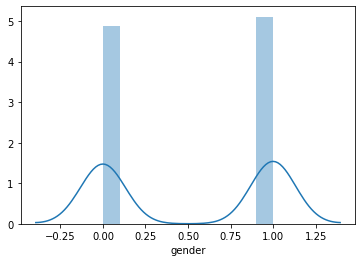

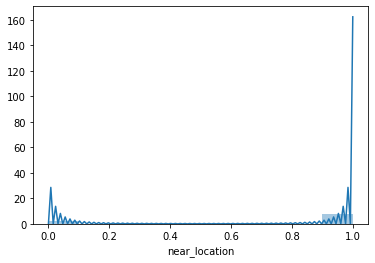

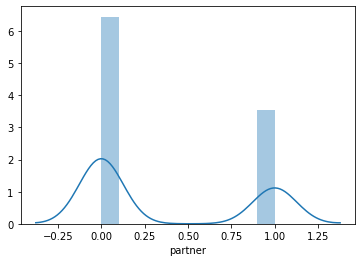

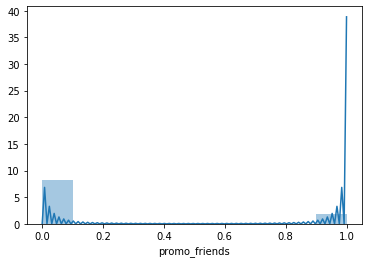

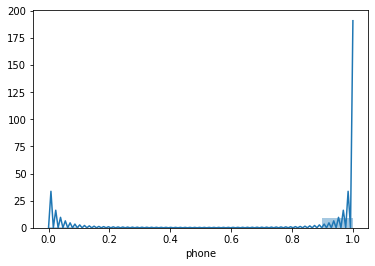

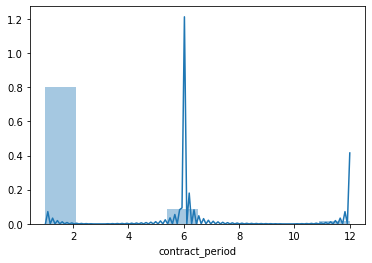

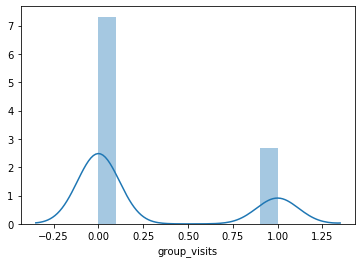

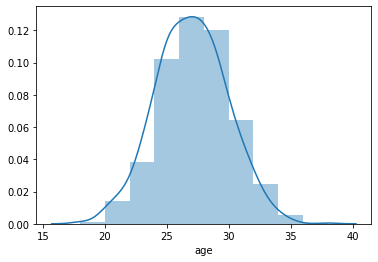

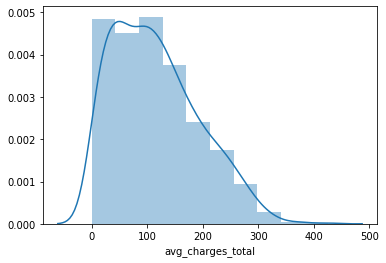

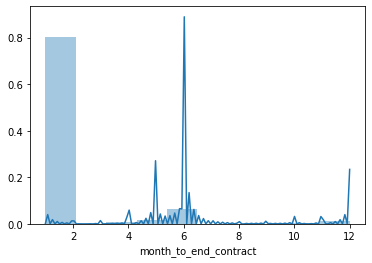

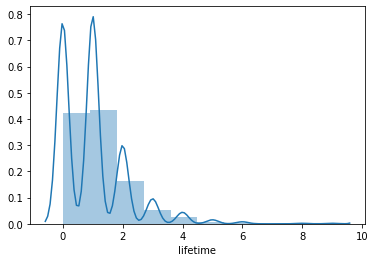

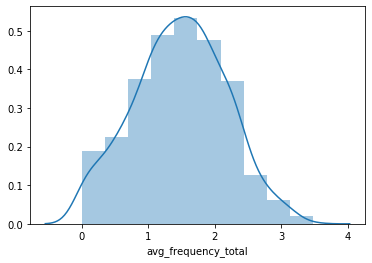

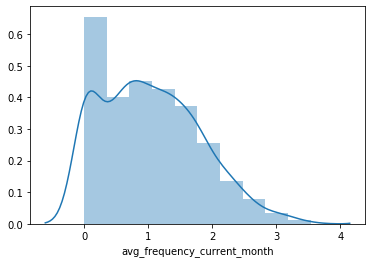

In [7]:
df = gym.query('churn == 1').drop(['churn'], axis=1)
print('Группа клиентов, которые ушли')
for col in df.columns:
  sns.distplot(df[col], bins = 10)
  plt.show()

Группа клиентов, которые остались


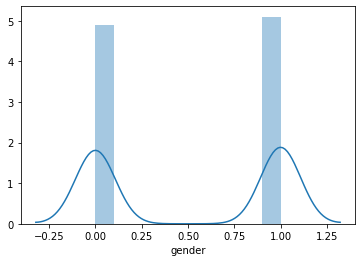

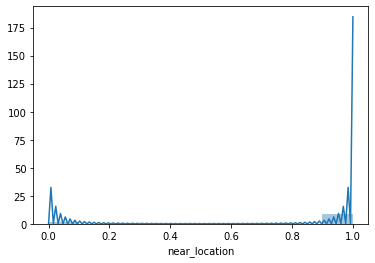

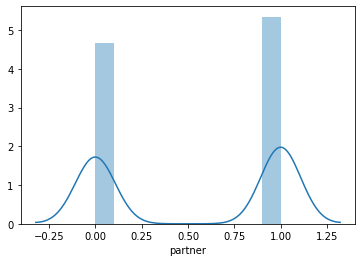

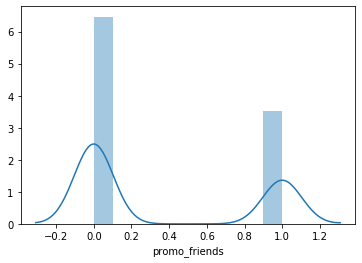

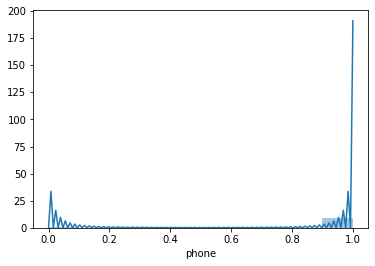

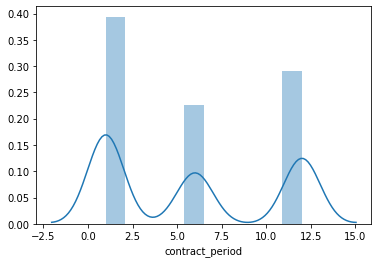

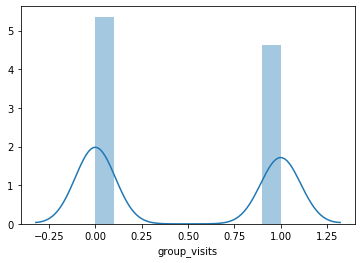

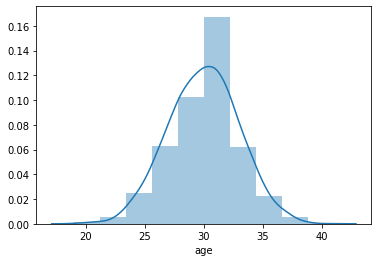

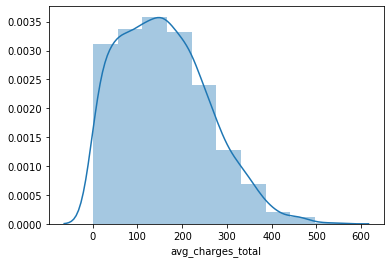

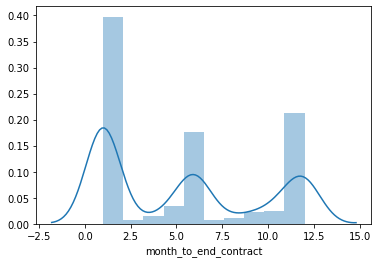

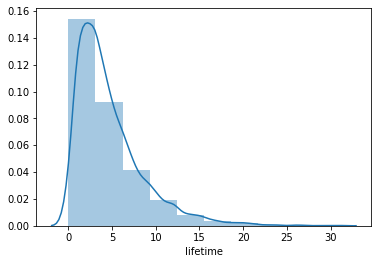

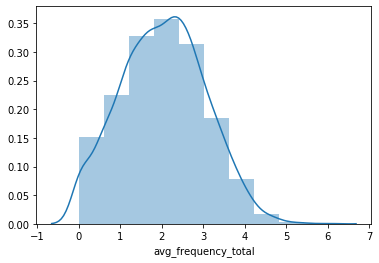

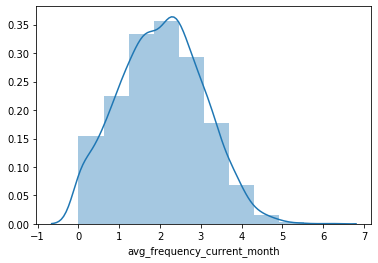

In [8]:
df = gym.query('churn == 0').drop(['churn'], axis=1)
print('Группа клиентов, которые остались')
for col in df.columns:
  sns.distplot(df[col], bins = 10)
  plt.show()

Нормальное распределение наблюдается далеко не у всех признаков в выборке.  
В данном случае нужно выполнить стандартизацию данных, но по заданию это требуется сделать только в пункте 4. Алгориты логистической регрессии вообще не чуствительны к распределению значений признаков?

#### Постройте матрицу корреляций и отобразите её.

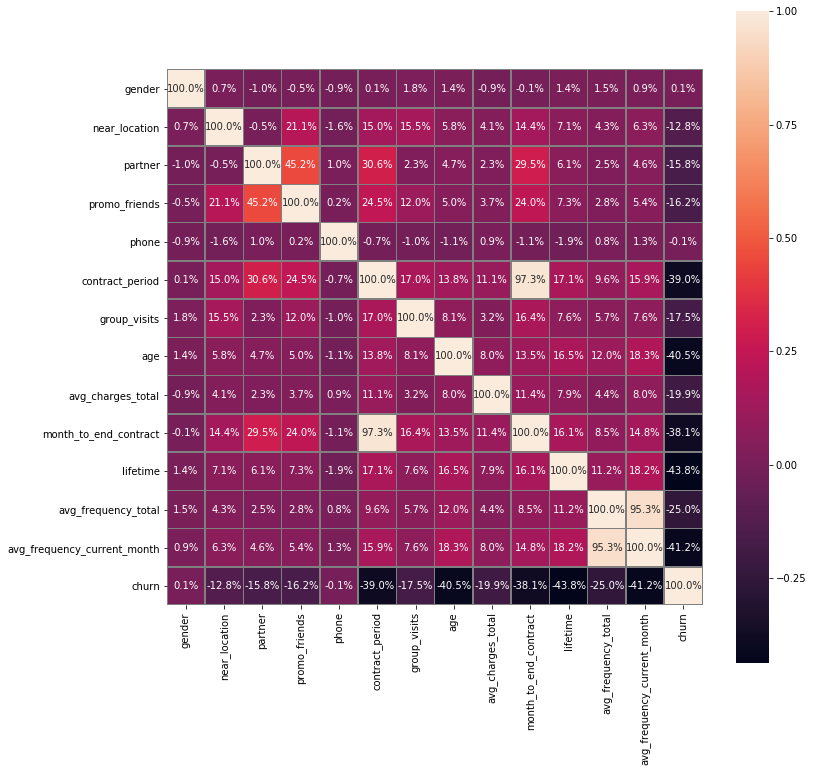

In [9]:
#построим и отрисуем матрицу корреляций
cm = gym.corr()
fig = plt.figure(figsize=(12,12))
# тепловая карта для матрицы корреляций
sns.heatmap(cm, 
            annot=True, 
            square=True,
            linewidths=.5, 
            linecolor='gray',
            fmt='.1%'
           )

# фикс кривизны отрисовки карты
b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t)

plt.show()

Выявлена сильная корреляция параметров:
- contract_period и month_to_end_contract
- avg_frequency_current_month и avg_frequency_total

Взаимосвязь признаков логически объяснима. Можно исключить лишние признаки из датасета и не использовать их в модели.

In [10]:
# убираем из набора признаки month_to_end_contract, avg_frequency_current_month
gym = gym.drop(['month_to_end_contract', 'avg_frequency_current_month'], axis = 1)
gym.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_charges_total,lifetime,avg_frequency_total,churn
0,1,1,1,1,0,6,1,29,14.227470,3,0.020398,0
1,0,1,0,0,1,12,1,31,113.202938,7,1.922936,0
2,0,1,1,0,1,1,0,28,129.448479,2,1.859098,0
3,0,1,1,1,1,12,1,33,62.669863,2,3.205633,0
4,1,1,1,1,1,1,0,26,198.362265,3,1.113884,0


<a id='step_3'></a>
### Шаг 3. Постройте модель прогнозирования оттока пользователей  
Постройте модель бинарной классификации пользователей, где целевой признак — факт оттока пользователя в следующем месяце

#### Разбейте данные на обучающую и валидационную выборку функцией train_test_split()

In [11]:
X = gym.drop('churn', axis = 1)
y = gym['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#### Обучите модель на train-выборке двумя способами:
- логистической регрессией
- случайным лесом

Оцените метрики accuracy, precision и recall для обеих моделей на валидационной выборке. Сравните по ним модели.

In [12]:
models = [LogisticRegression(random_state=0), RandomForestClassifier(random_state=0)]

for i in models:
    model = i
    model.fit(X_train, y_train)

    predictions = model.predict(X_test)
    probabilities = model.predict_proba(X_test)[:,1]
    
    print('model:', i)
    print('Accuracy: {:.2f}'.format(accuracy_score(y_test, predictions)))
    print('Precision: {:.2f}'.format(precision_score(y_test, predictions)))
    print('Recall: {:.2f}'.format(recall_score(y_test, predictions)))
    print()

model: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
Accuracy: 0.88
Precision: 0.76
Recall: 0.77

model: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)
Accuracy: 0.88
Precision: 0.77
Recall: 0.73



Метрика Accuracy (доля правильных ответов) - обе модели показали одинаковое значение
Метрика Precision (точность) - выше для модели RandomForestClassifier
Метрика Recall (полнота) - выше для модели LogisticRegression

В данном случае метрика Recall является главной при сравнении моделей. Более высокое значение recall означает, что для маркетинговых активностей по удержанию клиентов будет отобрано больше клиентов, которые потенциально могут покинуть фитнес-клуб. Потеря клиента более критична чем лишние затраты на маркетинг - удержать действующего клиента обычно существенно дешевле чем привлечь нового.  

По итогу сравнения метрик модель LogisticRegression показа себя лучше.

<a id='step_4'></a>
### Шаг 4. Сделайте кластеризацию пользователей
Отложите в сторону столбец с оттоком и проведите кластеризацию объектов (пользователей)

#### Стандартизируйте данные

In [13]:
# стандартизируем данные 
scaler = StandardScaler()
X_sc = scaler.fit_transform(gym.drop(columns = ['churn']))

#### Постройте матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуйте дендрограмму

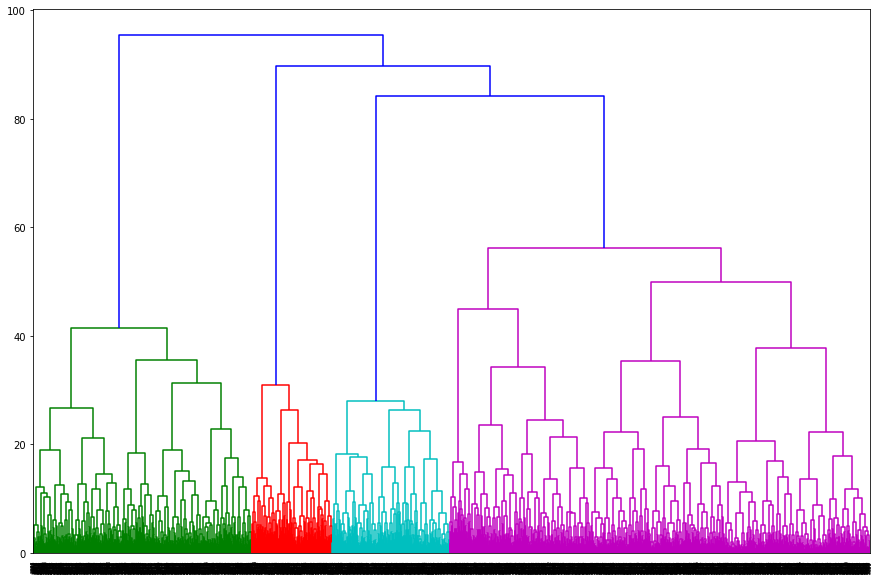

In [14]:
linked = linkage(X_sc, method = 'ward')

plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.show()

Можно выделить 5 или 8 кластеров. Меньше 5-ти будет недостаточно, скорее всего, чтобы учесть все особенности поведения. Больше 8 - дробление уже будет слишком мелкое и сложно будет затем маркетингу работать с таким числов сегментов клиентов. 

#### Обучите модель кластеризации на основании алгоритма K-Means и спрогнозируйте кластеры клиентов.  
Договоримся за число кластеров принять n=5

In [15]:
km = KMeans(n_clusters = 5) # задаём число кластеров, равное 5
labels = km.fit_predict(X_sc)

In [16]:
print(labels)

[2 3 4 ... 1 1 2]


In [17]:
gym['cluster'] = labels
gym.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_charges_total,lifetime,avg_frequency_total,churn,cluster
0,1,1,1,1,0,6,1,29,14.227470,3,0.020398,0,2
1,0,1,0,0,1,12,1,31,113.202938,7,1.922936,0,3
2,0,1,1,0,1,1,0,28,129.448479,2,1.859098,0,4
3,0,1,1,1,1,12,1,33,62.669863,2,3.205633,0,1
4,1,1,1,1,1,1,0,26,198.362265,3,1.113884,0,1


#### Посмотрите на средние значения признаков для кластеров. Можно ли сразу что-то заметить?

In [18]:
gym.groupby('cluster').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_charges_total,lifetime,avg_frequency_total,churn
cluster,,,,,,,,,,,,
0,0.500898,0.000000,0.488330,0.077199,1.0,2.978456,0.231598,28.685817,137.277472,2.978456,1.762672,0.402154
1,0.498495,0.994985,0.892678,1.000000,1.0,6.857573,0.519559,29.534604,152.517098,4.230692,1.956823,0.131394
2,0.523316,0.862694,0.471503,0.305699,0.0,4.777202,0.427461,29.297927,144.208179,3.940415,1.854211,0.266839
3,0.523921,0.995333,0.441074,0.010502,1.0,7.058343,0.535589,30.751459,179.540529,5.747958,2.324299,0.012835
4,0.510391,1.000000,0.187032,0.055694,1.0,1.941812,0.314214,27.971737,124.456544,2.140482,1.559159,0.492103


Кластер 0 - только клиенты без контактного телефона
Кластер 1 - выделяются признаки partner, promo_friends и contract_period
Кластер 2 - только клиенты без group_visits, т.е. не ходили на групповые занятия (о! это я)
Кластер 3 - только клиенты с near_location = 0, т.е. не живут или работают рядом с клубом 
Кластер 4 - все клиенты ходили на групповые занятия

#### Постройте распределения признаков для кластеров.  
Можно ли что-то заметить по ним?

In [19]:
# Признаки надо разбить на две группы: бинарные и остальные
feature_bin = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits']
feature_numeric = ['contract_period', 'age', 'avg_charges_total', 'lifetime', 'avg_frequency_total']

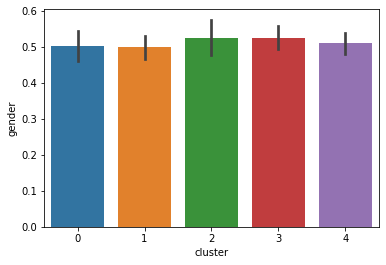

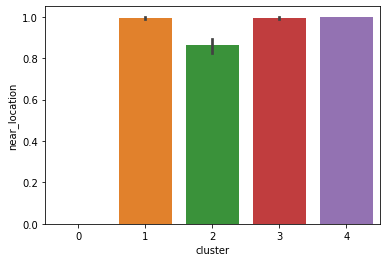

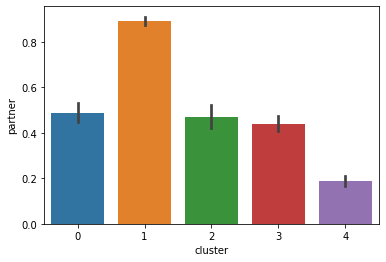

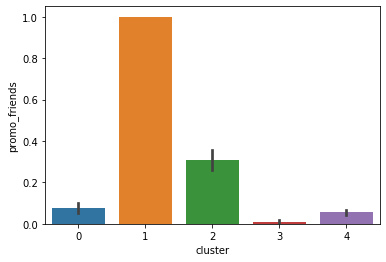

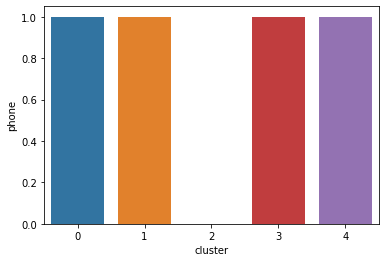

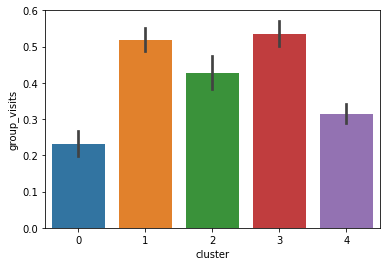

In [20]:
for col in feature_bin:
    sns.barplot(data=gym, x='cluster', y=col)
    plt.show()

По этим распределениям доп. выводов, кроме тех что выше, сделать не могу

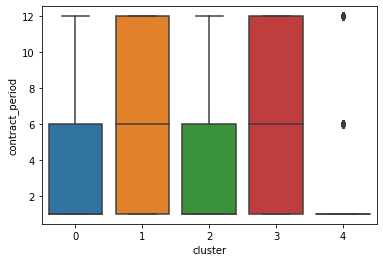

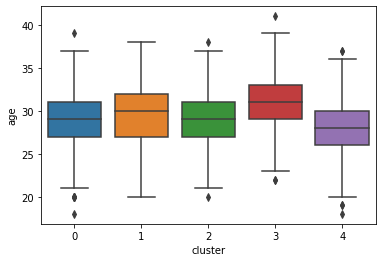

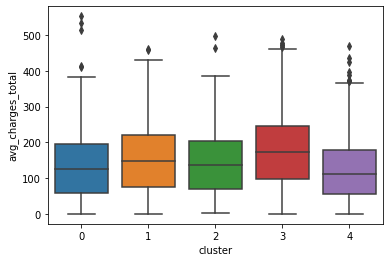

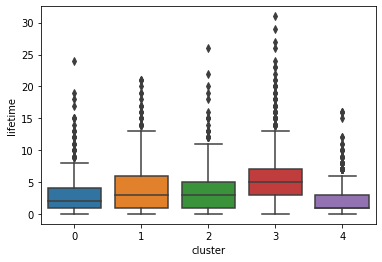

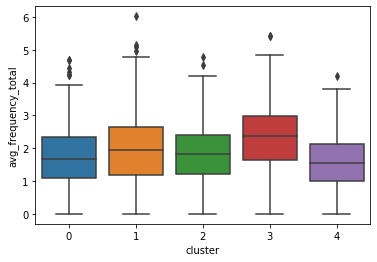

In [21]:
for col in feature_numeric:
    sns.boxplot(data=gym, x='cluster', y=col)
    plt.show()

Кластер 1 - contract_period (длительность действующего абонемента) явно выше чем у остальных

#### Для каждого полученного кластера посчитайте долю оттока (методом groupby()).  
Отличаются ли они по доле оттока? Какие кластеры склонны к оттоку, а какие — надёжны?

In [22]:
gym.groupby('cluster').agg({'churn': 'mean', 'age': 'count'})

,churn,age
cluster,,
0,0.402154,557
1,0.131394,997
2,0.266839,386
3,0.012835,857
4,0.492103,1203


- Самая надежная группа - 1  
- Также надежные группы - 0 и 4
- Склонные к оттоку - 2 и 3

<a id='step_5'></a>
### Шаг 5. Сформулируйте выводы и сделайте базовые рекомендации по работе с клиентами

Группы клиентов созданные в результате исследования:
- Кластер 0 - только клиенты без контактного телефона
- Кластер 1 - выделяются признаки partner, promo_friends и contract_period
- Кластер 2 - только клиенты без group_visits, т.е. не ходили на групповые занятия (о! это я)
- Кластер 3 - только клиенты с near_location = 0, т.е. не живут или работают рядом с клубом 
- Кластер 4 - все клиенты ходили на групповые занятия

Самая надежная группа клиентов - это сотрудники компаний-партнеров (получили скидку на клубную карту), использовали акцию "Приведи друга" (и возможно дальше ходят в клуб вместе) и у них "длинный" абонемент.

Наша маркетинговая стратегия - все остальные группы привести, по возможности, к 1-й группе. Активно рекламируем акцию "Приведи друга" среди текущих клиентов (предлагаем разные плюшки за новых друзей), продаем больше "длинных" абонементов - даем скидки и разные бонусы

Группа 4, которая отличается тем, что клиенты ходили на групповые занятия, относится к "устойчивым" группам - продвигаем групповые тренировки среди клиентов остальных групп

Маркетинговые усилия следует сконцентрировать на группе 2 - многочисленная и неустойчивая группа.